In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

In [29]:
# Replace with your actual file path
df = pd.read_csv('crop_data.csv')
df.head()


,State,District,Crop,Crop_Year,Season,Area,Production,Yield
0,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Kharif,2439.6,3415.0,1.40
1,Andaman and Nicobar Island,NICOBARS,Arecanut,2007,Rabi,1626.4,2277.0,1.40
2,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Autumn,4147.0,3060.0,0.74
3,Andaman and Nicobar Island,NICOBARS,Arecanut,2008,Summer,4147.0,2660.0,0.64
4,Andaman and Nicobar Island,NICOBARS,Arecanut,2009,Autumn,4153.0,3120.0,0.75


In [31]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()
print(df.columns)

Index(['State', 'District', 'Crop', 'Crop_Year', 'Season', 'Area',
       'Production', 'Yield'],
      dtype='object')


In [32]:
# Handle missing values
# Fill numerical columns with median, categorical with mode
df['Area'] = df['Area'].fillna(df['Area'].median())
df['Crop_Year'] = df['Crop_Year'].fillna(df['Crop_Year'].median())
df['Yield'] = df['Yield'].fillna(df['Yield'].median())
df['State'] = df['State'].fillna(df['State'].mode()[0])
df['District'] = df['District'].fillna(df['District'].mode()[0])
df['Crop'] = df['Crop'].fillna(df['Crop'].mode()[0])
df['Season'] = df['Season'].fillna(df['Season'].mode()[0])

In [33]:
# Print missing values after handling
print("\nMissing Values After Handling:\n", df.isnull().sum())


Missing Values After Handling:
 State            0
District         0
Crop             0
Crop_Year        0
Season           0
Area             0
Production    4948
Yield            0
dtype: int64


In [34]:
# One-hot encode categorical variables (State, Crop, Season)
# Drop District to avoid high dimensionality (can be included if needed)
df = pd.get_dummies(df, columns=['State', 'Crop', 'Season'], drop_first=True)

In [35]:
# Define features and target
X = df.drop(columns=['Yield', 'District'])  # Exclude target and District
y = df['Yield']

In [36]:
# Scale numerical features (Area, Crop_Year) for better model stability
scaler = StandardScaler()
X[['Area', 'Crop_Year']] = scaler.fit_transform(X[['Area', 'Crop_Year']])

In [37]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Initialize Decision Tree Regressor
base_model = DecisionTreeRegressor(random_state=42)

In [39]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [40]:
# Best model from grid search
model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validated R² Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Cross-Validated R² Score: 0.8767843297352498


In [41]:
# Train the best model
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=42)

In [42]:
# Make predictions
y_pred = model.predict(X_test)

In [43]:
# Evaluate model
print("\nTest Set Evaluation:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


Test Set Evaluation:
R² Score: 0.8632305575515874
MAE: 25.566951700959795
RMSE: 342.5591469173955


In [44]:
# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("\nCross-Validation R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean(), "±", cv_scores.std())


Cross-Validation R² Scores: [0.7079977  0.45978305 0.19484226 0.69453942 0.87401496]
Mean CV R²: 0.5862354764382942 ± 0.23603037120170253


In [45]:
# Feature importance plot
importances = model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

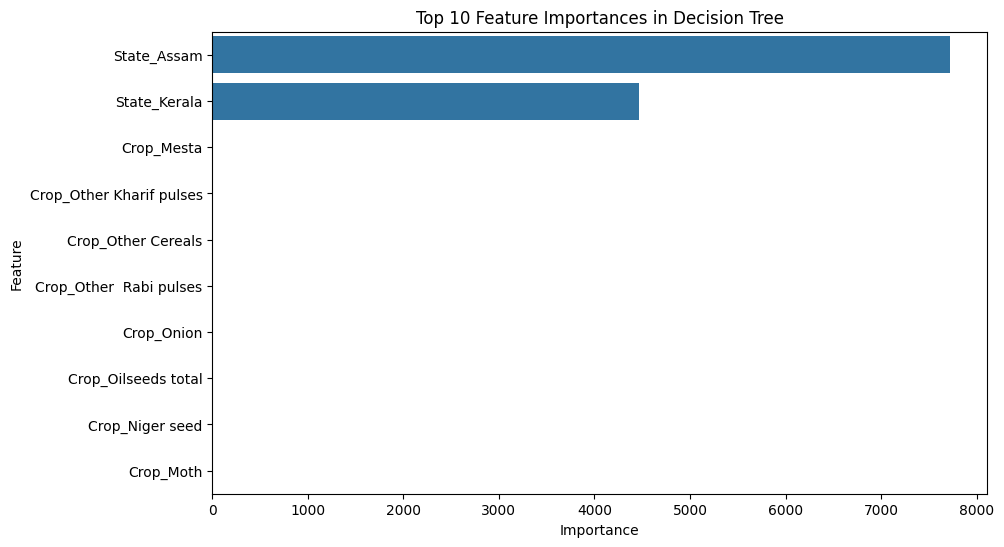

In [46]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))  # Top 10 features
plt.title("Top 10 Feature Importances in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

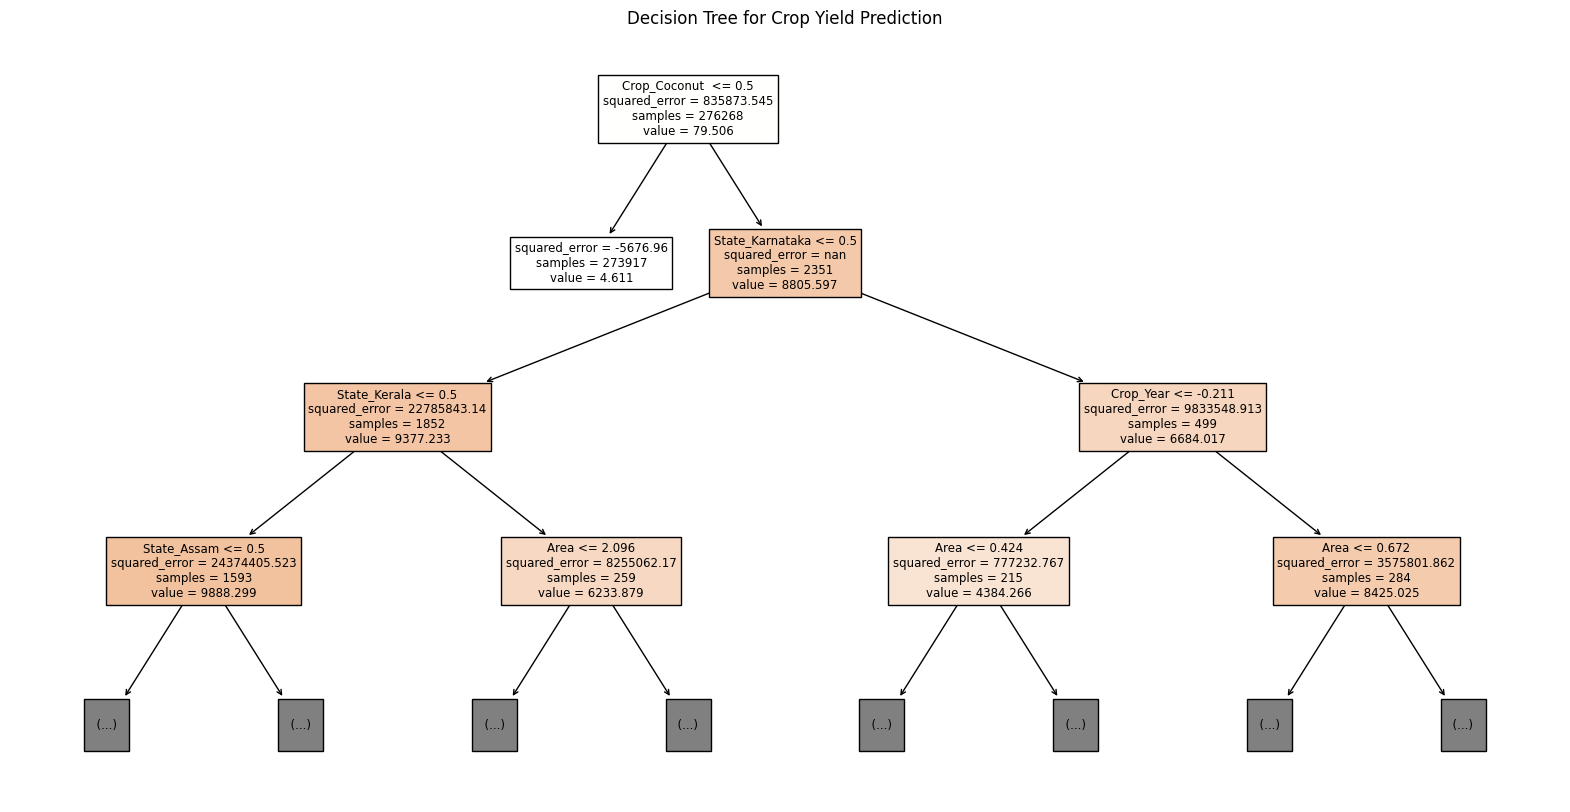

In [47]:
# Visualize the decision tree (limited depth for readability)
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, filled=True, max_depth=3)  # Limit depth for clarity
plt.title("Decision Tree for Crop Yield Prediction")
plt.show()

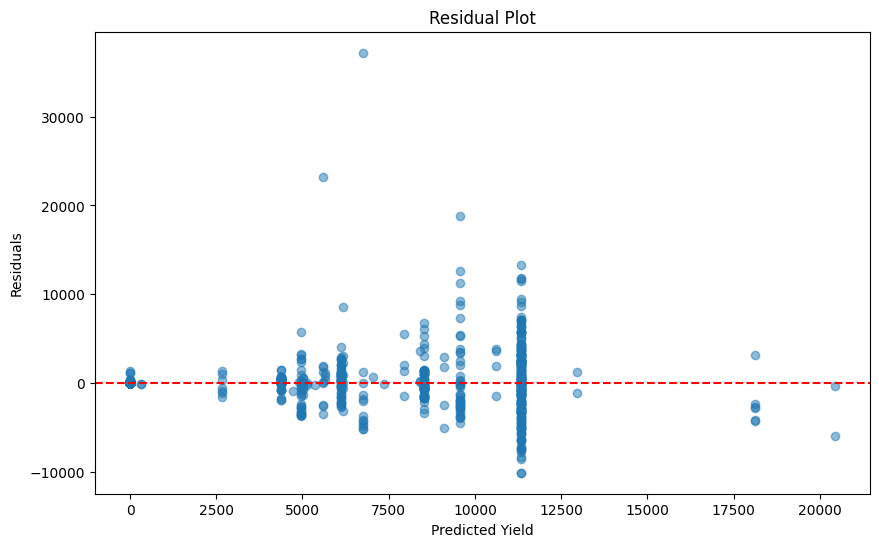

In [48]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Yield")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


Example Prediction for a New Data Point:
Input Features:
         Crop_Year      Area  Production  State_Andhra Pradesh  \
212198    1.23584 -0.250683      3650.0                 False   

        State_Arunachal Pradesh  State_Assam  State_Bihar  State_CHANDIGARH  \
212198                    False        False        False             False   

        State_Chhattisgarh  State_Dadra and Nagar Haveli  ...  Crop_Tobacco  \
212198               False                         False  ...         False   

        Crop_Turmeric  Crop_Urad  Crop_Wheat  Crop_other oilseeds  \
212198          False      False       False                False   

        Season_Kharif       Season_Rabi         Season_Summer       \
212198                True               False               False   

        Season_Whole Year   Season_Winter       
212198               False               False  

[1 rows x 98 columns]
Predicted Yield: 4.610740516287762

Predicted Yield by State for Resource Allocation:
     

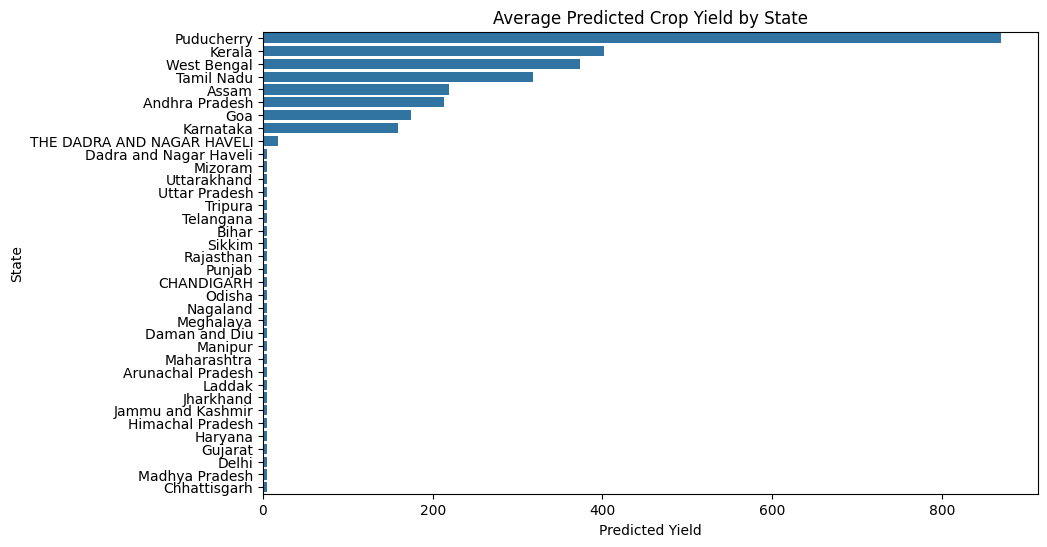

In [49]:
# Predict yield for a new sample
# a new data point (match X's structure)
new_data = X_test.iloc[0:1].copy()  # Use a sample from test set as template
new_pred = model.predict(new_data)
print("\nExample Prediction for a New Data Point:")
print("Input Features:\n", new_data)
print("Predicted Yield:", new_pred[0])

# Resource allocation: Analyze predicted yields by encoded State
# Inverse transform one-hot encoded State columns to original names
state_columns = [col for col in X.columns if col.startswith('State_')]
state_yield = X_test[state_columns].copy()
state_yield['Predicted_Yield'] = y_pred
state_yield['State'] = state_yield[state_columns].idxmax(axis=1).str.replace('State_', '')

# Group by State to summarize predicted yields
yield_by_state = state_yield.groupby('State')['Predicted_Yield'].mean().reset_index()
print("\nPredicted Yield by State for Resource Allocation:")
print(yield_by_state)

# Plot predicted yields by State
plt.figure(figsize=(10, 6))
sns.barplot(x='Predicted_Yield', y='State', data=yield_by_state.sort_values('Predicted_Yield', ascending=False))
plt.title("Average Predicted Crop Yield by State")
plt.xlabel("Predicted Yield")
plt.ylabel("State")
plt.show()